## **Interpretable Machine Learning: SHAP Analysis of Credit Risk Model**

## **IMPORT LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns


## **Display 5 row of dataset**

In [ ]:
from sklearn.datasets import fetch_openml
import pandas as pd

data = fetch_openml("credit-g", version=1, as_frame=True)
df = data.frame.copy()

df.head()


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


## **Class Risk - Good/Bad**

In [ ]:
df['class'] = df['class'].map({'good': 0, 'bad': 1})
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,0
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,1
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,0
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,0
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,1


## **preprocess**- split

In [ ]:
y = df["class"]
X = df.drop("class", axis=1)

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## **Train and Hyperparameter grid**

In [ ]:
params = {
    "num_leaves": [31, 50],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 300]
}


## **Gradient Boosting Machine (LightGBM)**

In [ ]:
model = LGBMClassifier()

grid = GridSearchCV(model, params, cv=5, scoring="f1", n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 241, number of negative: 559
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301250 -> initscore=-0.841353
[LightGBM] [Info] Start training from score -0.841353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

## **Model Evaluation**

In [ ]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)

print("AUC:", auc)
print("F1 Score:", f1)
print(classification_report(y_test, y_pred))

AUC: 0.819088832792403
F1 Score: 0.6262626262626263
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       141
           1       0.78      0.53      0.63        59

    accuracy                           0.81       200
   macro avg       0.80      0.73      0.75       200
weighted avg       0.81      0.81      0.80       200



## **SHAP Analysis**

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


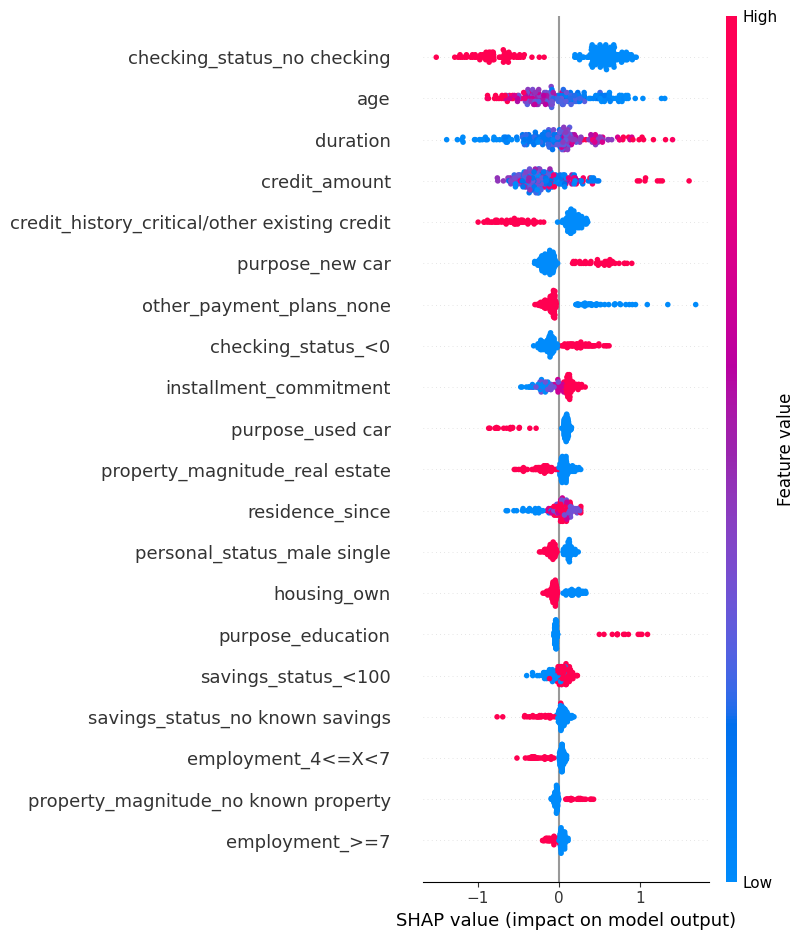

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)



## **Extract Features and Plot**

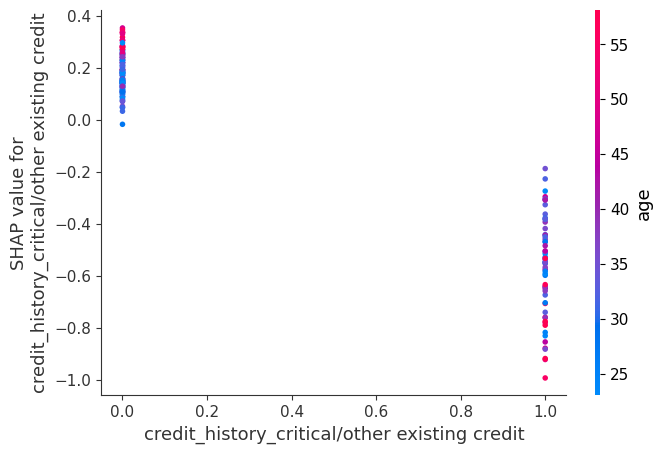

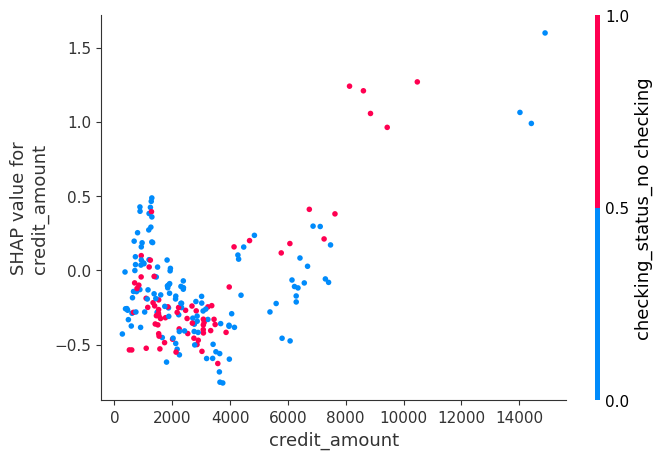

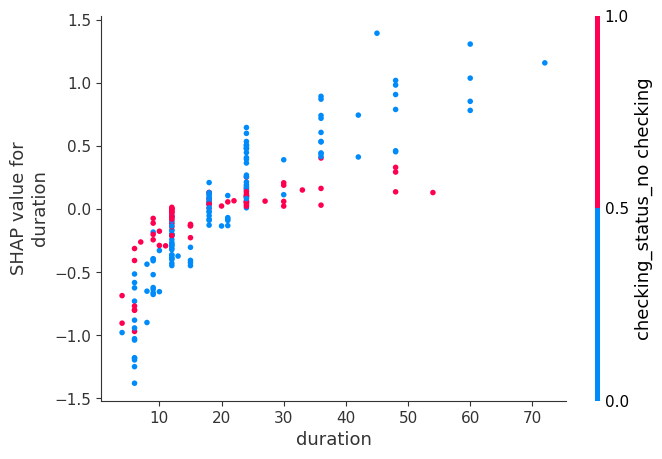

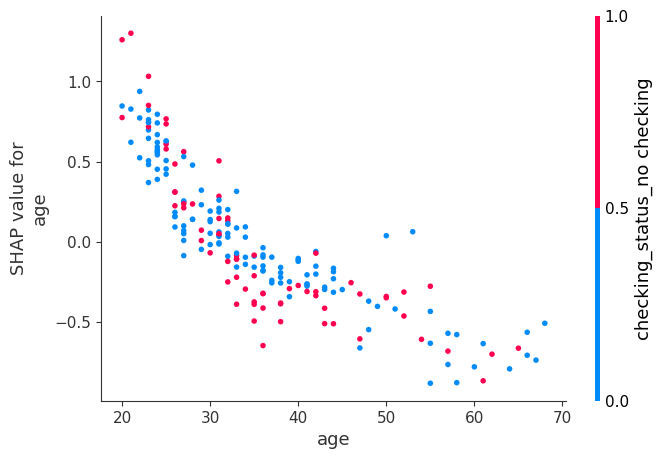

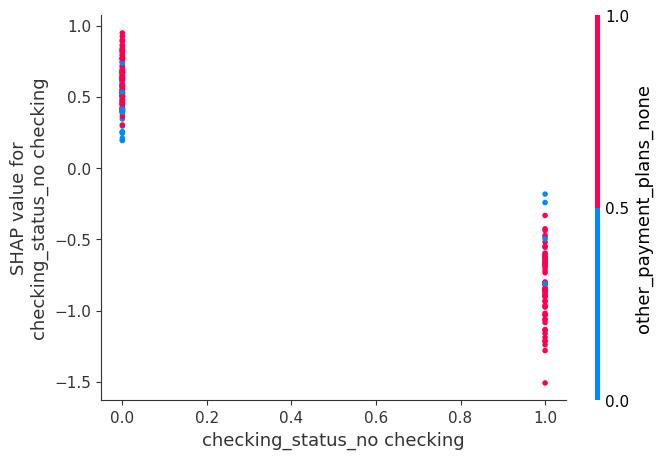

In [ ]:
top_features = X_test.columns[np.argsort(np.abs(shap_values).mean(0))[-5:]]

for f in top_features:
    shap.dependence_plot(f, shap_values, X_test)

## **SHAP Explanation**

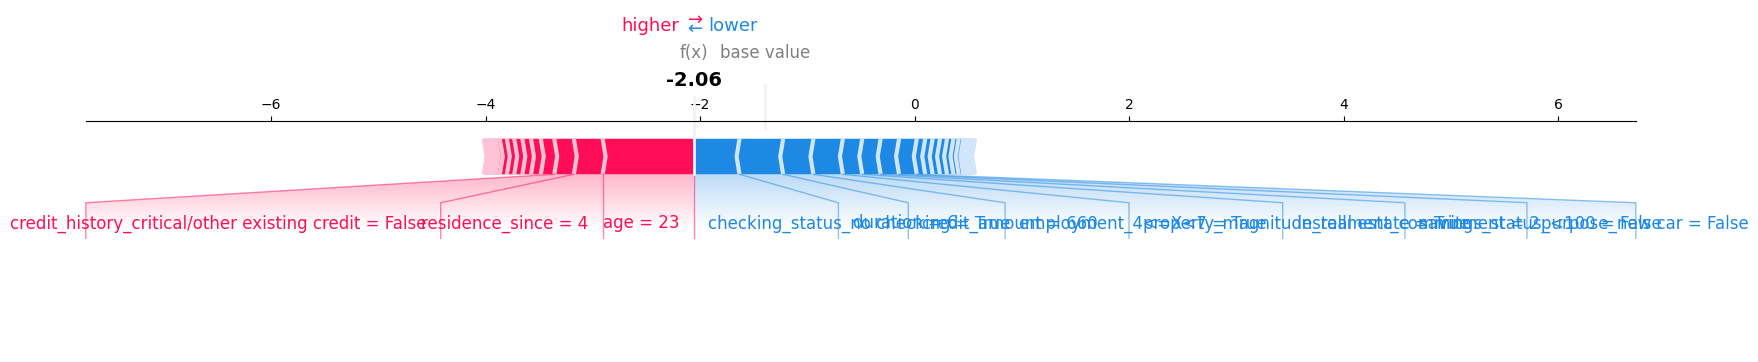

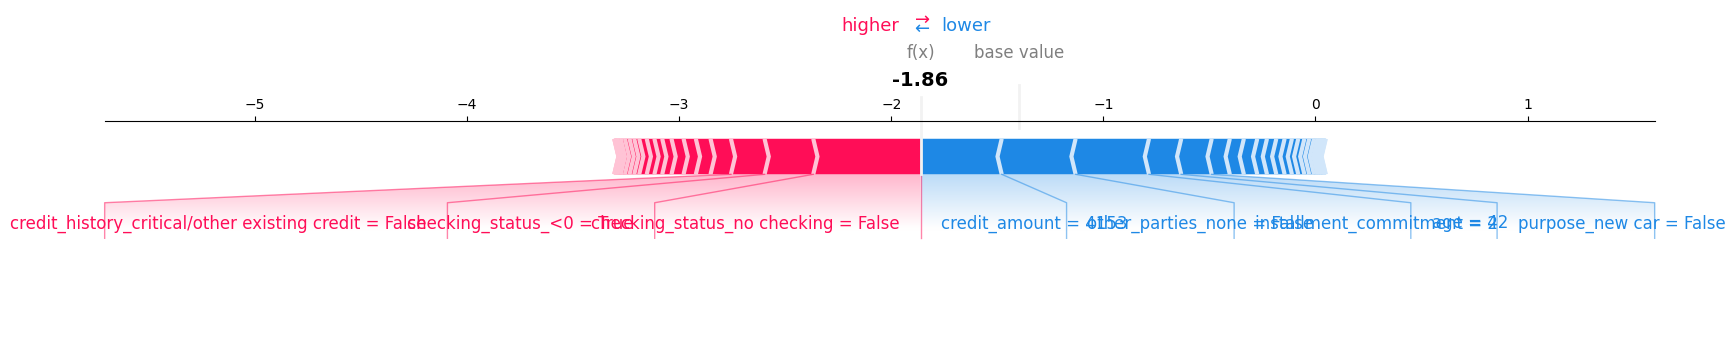

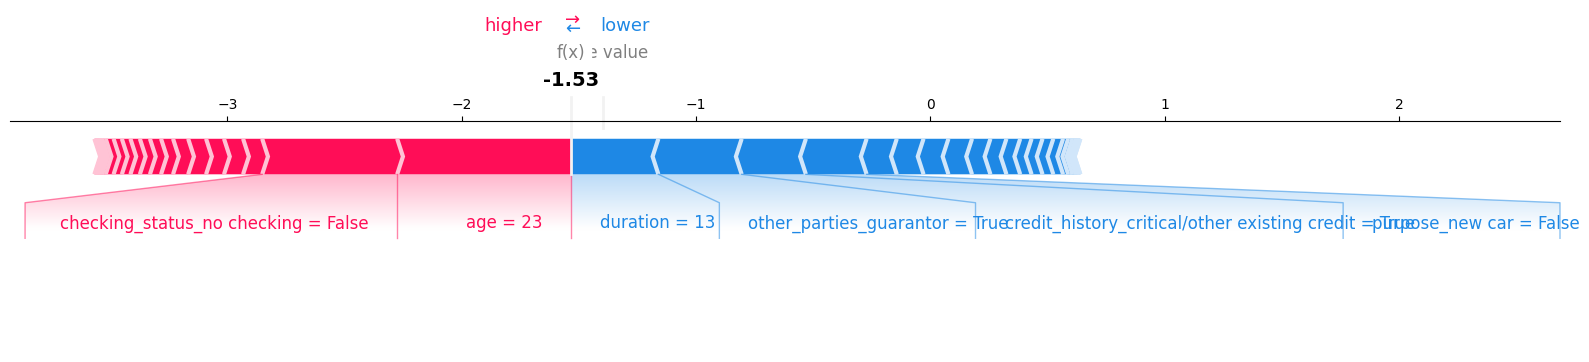

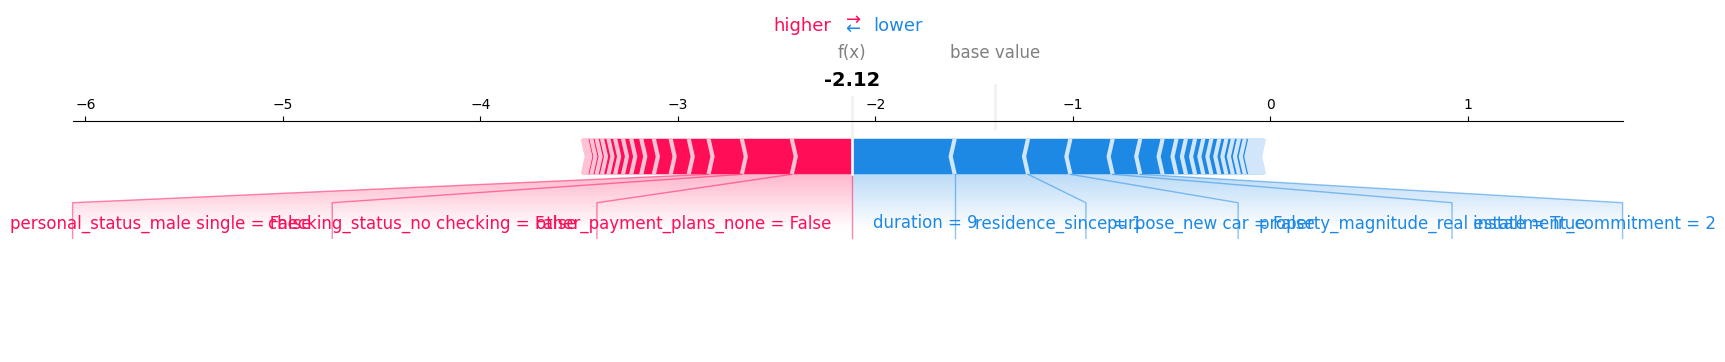

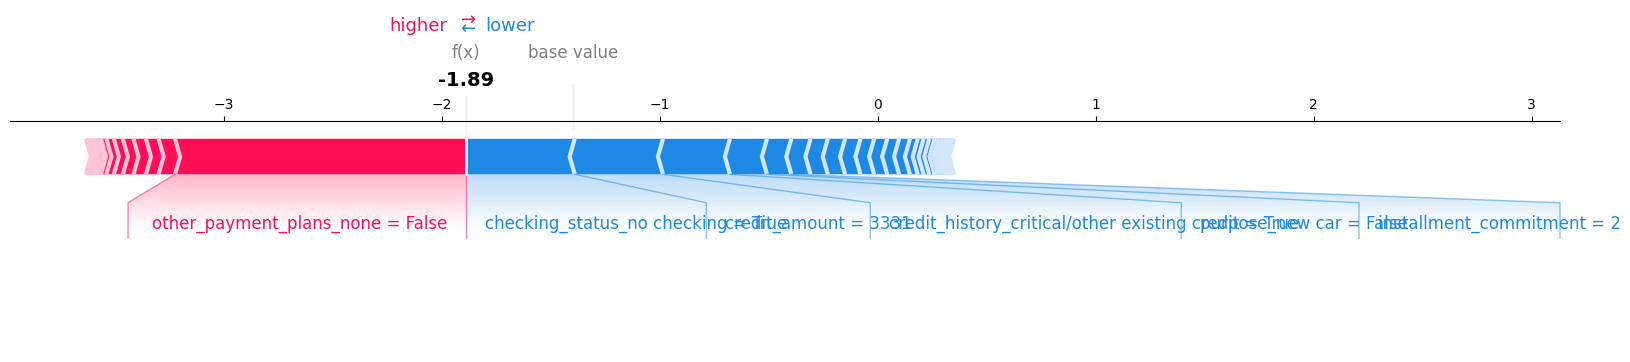

In [ ]:
expected_value_for_class_1 = explainer.expected_value

instances = X_test.sample(5, random_state=42)

for original_idx, instance_row in instances.iterrows():
    pos_idx = X_test.index.get_loc(original_idx)

    shap.force_plot(
        expected_value_for_class_1,
        shap_values[pos_idx]
        instance_row,
        matplotlib=True
    )

## **SHAP Age Group**

In [ ]:
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 60], labels=["young", "adult"])

#Compare Average SHAP Values by Age Group

group_shap = pd.DataFrame(shap_values, columns=X_test.columns)
group_shap['age_group'] = df.loc[X_test.index, 'age_group']

group_means = group_shap.groupby("age_group").mean().T
group_means.head()

/tmp/ipython-input-644488767.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_means = group_shap.groupby("age_group").mean().T


age_group,young,adult
duration,-0.276939,0.042204
credit_amount,-0.219933,-0.190368
installment_commitment,-0.008145,-0.001761
residence_since,-0.024285,0.029084
age,0.141343,-0.010847


## **Average Difference bettween Age Group**

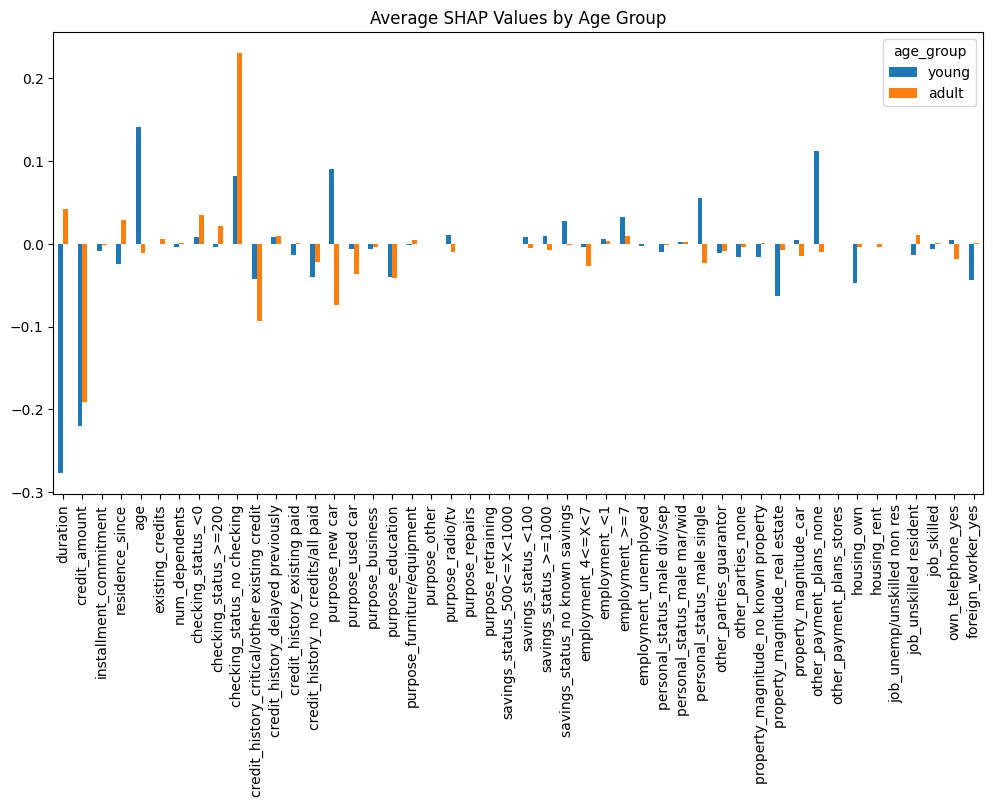

In [ ]:
group_means.plot(kind='bar', figsize=(12,6))
plt.title("Average SHAP Values by Age Group")
plt.show()